In [1]:
#!/usr/bin/env python3

import json
import re
import requests
import matplotlib.pyplot as plt
from matplotlib.dates import *
from matplotlib.ticker import *
import pandas as pd
from datetime import datetime, timezone, timedelta
from dataclasses import dataclass, field, asdict
import numpy as np

from enum import Enum

from collections import defaultdict
from typing import Optional

from multiprocessing import Pool

import geopandas

In [2]:
class ScheduleType(str, Enum):
    UNIFORM_RANDOM = "uniform-random"
    POISSON = "poisson"
    ONETIME = "onetime"

class CarbonAccountingMode(str, Enum):
    ComputeOnly = "compute-only"
    ComputeAndNetwork = "compute-and-network"

class CarbonDataSource(str, Enum):
    C3Lab = "c3lab"
    Azure = "azure"
    EMap = "emap"

class InterRegionRouteSource(str, Enum):
    ITDK = "itdk"
    IGDB_NO_POPS = "igdb.no-pops"
    IGDB_WITH_POPS = "igdb.with-pops"
    ITDK_AND_IGDB_NO_POPS = "itdk+igdb.no-pops"
    ITDK_AND_IGDB_WITH_POPS = "itdk+igdb.with-pops"

@dataclass
class Dataset:
    input_size_gb: float
    output_size_gb: float

@dataclass
class WorkloadSchedule:
    start_time: datetime
    type: Optional[ScheduleType] = ScheduleType.ONETIME
    max_delay: Optional[timedelta] = timedelta()

    def asdict(self) -> dict:
        d = asdict(self)
        d["start_time"] = self.start_time.isoformat()
        d["type"] = self.type.value
        d["max_delay"] = self.max_delay.total_seconds()
        return d

@dataclass
class Workload:
    runtime: timedelta
    schedule: WorkloadSchedule
    dataset: Dataset

    original_location: str


    carbon_data_source: CarbonDataSource = CarbonDataSource.EMap
    use_prediction: bool = field(default=False)
    optimize_carbon: bool = field(default=True)

    watts_per_core: float = field(default=5.0)
    core_count: float = field(default=1.0)

    use_new_optimization: bool = field(default=True)
    carbon_accounting_mode: CarbonAccountingMode = CarbonAccountingMode.ComputeAndNetwork
    candidate_providers: Optional[list[str]] = None
    candidate_locations: Optional[list[str]] = None
    # desired_renewable_ratio: Optional[float] = 1.0

    def asdict(self) -> dict:
        d = asdict(self)
        d["schedule"] = self.schedule.asdict()
        d["runtime"] = self.runtime.total_seconds()
        d["carbon_accounting_mode"] = self.carbon_accounting_mode.value
        d["carbon_data_source"] = self.carbon_data_source.value
        return d
    
    inter_region_route_source: InterRegionRouteSource = InterRegionRouteSource.ITDK

In [17]:
def get_best_region(original_region: str, raw_scores: dict) -> str:
    min_co2e = raw_scores[original_region]["carbon-emission"]
    min_region = original_region
    for region, scores in raw_scores.items():
        if scores["carbon-emission"] < min_co2e:
            min_co2e = scores["carbon-emission"]
            min_region = region

    return min_region

In [3]:
CARBON_API_URL='http://yak-03.sysnet.ucsd.edu/carbon-aware-scheduler/'

In [71]:
response = requests.get(CARBON_API_URL, json=Workload(
    runtime=timedelta(hours=1),
    schedule=WorkloadSchedule(
        start_time=datetime(year=2023, month=6, day=1, tzinfo=timezone.utc),
        max_delay=timedelta(hours=24),
    ),
    dataset=Dataset(
        input_size_gb=250,
        output_size_gb=250
    ),
    original_location="AWS:us-east-1",
    candidate_providers=["AWS"],
    inter_region_route_source=InterRegionRouteSource.ITDK_AND_IGDB_WITH_POPS,
).asdict())

assert response.ok, f"Error: API call failed with status code {response.status_code}: {response.text}"
data = response.json(parse_float=lambda s: float('%.6g' % float(s)))

pd.Series(data)

# print(json.dumps(data, indent=4))

request            {'runtime': '01:00:00', 'schedule': {'type': '...
original-region                                        AWS:us-east-1
isos               {'AWS:af-south-1': 'emap:ZA', 'AWS:ap-northeas...
warnings           {'AWS:ap-northeast-1': 'Carbon data not availa...
details            {'AWS:af-south-1': {'timings': [{'input_transf...
optimal-regions    [{'rating': 2.45148, 'candidates': ['AWS:us-ea...
weighted-scores    {'AWS:af-south-1': 156.607, 'AWS:ap-northeast-...
raw-scores         {'AWS:af-south-1': {'energy-usage': 0.005, 'ca...
dtype: object

In [48]:
data = {}

for max_delay in range(2,25,2):
    runtime = timedelta(hours=6)
    response = requests.get(CARBON_API_URL, json=Workload(
        runtime=runtime,
        schedule=WorkloadSchedule(
            start_time=datetime(year=2023, month=6, day=1, tzinfo=timezone(-timedelta(hours=8))),
            max_delay=max(timedelta(hours=max_delay) - runtime, timedelta()),
        ),
        dataset=Dataset(
            input_size_gb=250,
            output_size_gb=250
        ),
        core_count=100,
        original_location="AWS:us-east-1",
        candidate_providers=["AWS"],
        inter_region_route_source=InterRegionRouteSource.ITDK_AND_IGDB_WITH_POPS,
    ).asdict())
    d = response.json(parse_float=lambda s: float('%.6g' % float(s)))
    data[max_delay] = d

df = pd.DataFrame(data)
df = df.T

df["best_region"] = df.apply(lambda x: get_best_region(x["original-region"], x["raw-scores"]), axis=1)
df["best_gco2e"] = df.apply(lambda row: row["raw-scores"][row["best_region"]]["carbon-emission"], axis=1)
df["original_gco2e"] = df.apply(lambda row: row["raw-scores"][row["original-region"]]["carbon-emission"], axis=1)

<Axes: >

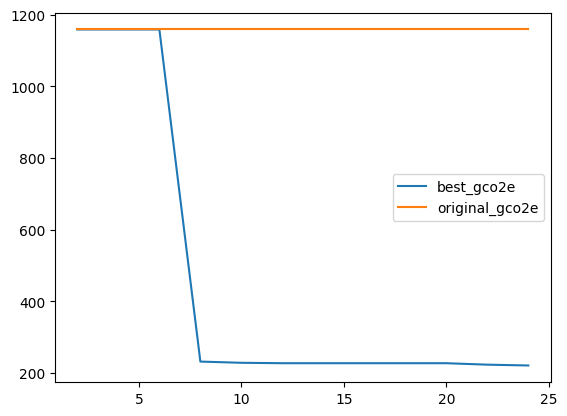

In [49]:
df.plot(column="best_gco2e")

In [60]:
df["compute_start"] = df.apply(lambda x: x.details[x.best_region]["timings"][0]["compute_start"], axis=1)
df[["best_region", "best_gco2e", "compute_start"]]

,best_region,best_gco2e,compute_start
2,AWS:us-east-1,1158.310,2023-06-01T00:00:00-08:00
4,AWS:us-east-1,1158.310,2023-06-01T00:00:00-08:00
6,AWS:us-east-1,1158.310,2023-06-01T00:00:00-08:00
8,AWS:ca-central-1,231.538,2023-06-01T01:26:40-08:00
10,AWS:ca-central-1,228.190,2023-06-01T03:26:40-08:00
12,AWS:ca-central-1,227.017,2023-06-01T04:26:40-08:00
14,AWS:ca-central-1,227.017,2023-06-01T04:26:40-08:00
16,AWS:ca-central-1,227.017,2023-06-01T04:26:40-08:00
18,AWS:ca-central-1,227.017,2023-06-01T04:26:40-08:00
20,AWS:ca-central-1,227.017,2023-06-01T04:26:40-08:00


{'runtime': '06:00:00',
 'schedule': {'type': 'onetime',
  'start_time': '2023-06-01T00:00:00-08:00',
  'interval': None,
  'max_delay': '00:00:00'},
 'dataset': {'input_size_gb': 250.0, 'output_size_gb': 250.0},
 'original_location': 'AWS:us-east-1',
 'candidate_providers': ['AWS'],
 'candidate_locations': None,
 'carbon_data_source': 'emap',
 'use_prediction': False,
 'desired_renewable_ratio': None,
 'optimize_carbon': True,
 'only_emap_full_range_isos_for_network_hops': False,
 'watts_per_core': 5.0,
 'core_count': 100.0,
 'use_new_optimization': True,
 'carbon_accounting_mode': 'compute-and-network',
 'inter_region_route_source': 'itdk+igdb.with-pops',
 'network_hop_carbon_estimation_heuristic': 'route-average',
 'network_hop_carbon_estimation_minimum_known_carbon_power_ratio': 0.75,
 'network_hop_carbon_estimation_route_average_ratio_threshold': 0.75,
 'network_hop_carbon_estimation_distance_km_threshold': 50000}

In [207]:
data_dir = "./time_shifting/results/"
args = []
start_times = [datetime(year=2023, month=m, day=1, hour=h, tzinfo=timezone.utc) for m in range(1,13) for h in range(0,24,6)]

for region in ["AWS:us-east-1", "AWS:eu-west-1"]:
    for t in start_times:
        for runtime in [timedelta(hours=h) for h in range(2, 13, 2)]:
            for max_delay in [timedelta(hours=h) for h in range(0, 25, 2)]:
                args.append((region, t, runtime, max_delay))


data = []
for arg in args:
    reg, t, rt, d = arg
    s = pd.read_pickle(data_dir + f"{reg}_{t.isoformat()}_{rt}_{d}.pkl")
    s["region"] = reg
    s["request_time"] = t
    s["runtime"] = rt
    s["max_delay"] = d
    s["best_region"] = get_best_region(s["original-region"], s["raw-scores"])
    s["best_gco2e"] = s["raw-scores"][s["best_region"]]["carbon-emission"]
    s["original_gco2e"] = s["raw-scores"][s["original-region"]]["carbon-emission"]
    s["compute_start"] = s.details[s.best_region]["timings"][0]["compute_start"]

    data.append(s)
    # data[arg] = s
    # print(s["Unnamed: 0"].values)
    # print(s["0"])
    # print(s.T.columns)
    



In [406]:
p = pd.DataFrame(data) \
    .pivot(
        index=["max_delay", "runtime", "request_time"],
        columns="region",
        values=["best_gco2e", "original_gco2e"]).stack(level=1)

p["pct_reduction"] = p.pct_change(axis="columns", periods=-1).best_gco2e

In [675]:
t = p.reorder_levels(["runtime", "request_time", "region",  "max_delay"])
# t.unstack(level=0).original_gco2e.apply(lambda x: p.loc[timedelta()].original_gco2e.loc[x.index], axis=1)
t["test"] = t.apply(lambda x: p.loc[timedelta()].original_gco2e.loc[x.name[:-1]], axis=1)
t = t.reorder_levels(["runtime", "max_delay", "request_time", "region"])

t = t.unstack(level=3)

t = t.join(pd.DataFrame(((t.test - t.original_gco2e) / t.test).values,
             columns=pd.MultiIndex.from_product([["pct_time"], t.test.columns]),
             index=t.test.index))


t = t.join(pd.DataFrame(((t.test - t.best_gco2e) / t.test).values,
             columns=pd.MultiIndex.from_product([["pct_space"], t.test.columns]),
             index=t.test.index))

t2 = t.loc[timedelta(hours=2)] \
     .loc[[timedelta(hours=4), timedelta(hours=24)]][["pct_time", "pct_space"]] \
     .unstack(level=0)#.xs("AWS:eu-west-1", level=1, axis=1)


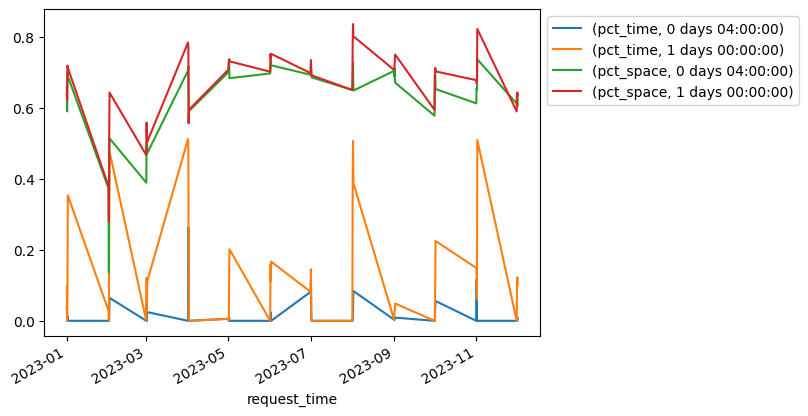

In [676]:
fig, ax = plt.subplots()

t2.xs("AWS:eu-west-1", level=1, axis=1).plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

Timestamp('2023-01-01 00:00:00+0000', tz='UTC')

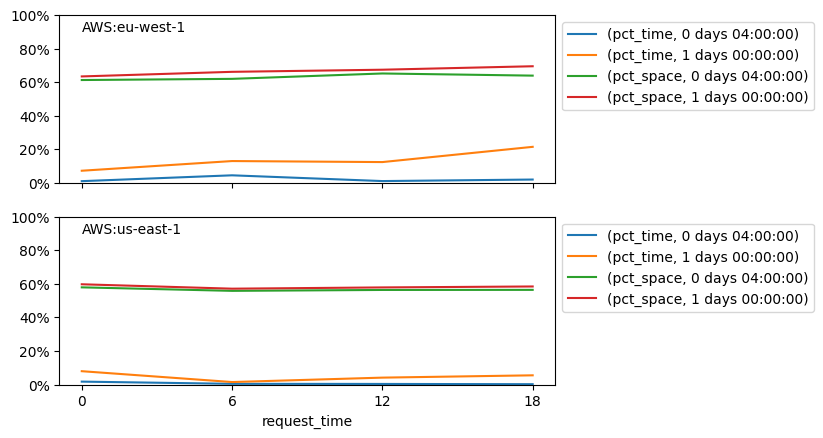

In [677]:
fig, axes = plt.subplots(2, 1, sharex=True)


avg = t2.groupby(t2.index.hour).mean()
std = t2.groupby(t2.index.hour).std()

all = t2.groupby(t2.index.hour).describe()

for ax, dc in zip(axes, ["AWS:eu-west-1", "AWS:us-east-1"]):
    d = avg.xs(dc, level=1, axis=1)
    d.plot(ax=ax)    
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(6))
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    ax.set_ylim(0,1)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.annotate(dc, xy=(0,0.9))

plt.show()